## Import library

In [27]:
# Example 2 is inbalanced data set; ~2200 in PD and ~1100 in SNP
# Goal is to predict if protein is a SNP or PD

#Imports the required libraries and packages
import pandas as pd  #Import for data manipulation in dataframes
import numpy as np  #Array manipulation and calculates mean
import matplotlib.pyplot as plt  #Graphing and plotting
# show figures in jupyter instead of prompt window
%matplotlib inline 

import random as rd
import time
import sys

from sklearn import tree

from sklearn.metrics import(
    matthews_corrcoef,  # CC for evaluation
    f1_score,  #F1 score for evaluation
    balanced_accuracy_score, roc_auc_score, make_scorer,  #Scoring metrics
    confusion_matrix,  #Creates the confusion matrix - stats on how accurate the test set output is
    classification_report #Returns the F1 socre, precision, and recall of a prediction using a given model
    )
from sklearn.model_selection import(
    train_test_split,  # Splits data frame into the training set and testing set
    GridSearchCV,  # Cross validation to improve hyperparameters
    StratifiedKFold
        )
from sklearn.ensemble import RandomForestClassifier #SK learn API for classificastion random forests
from sklearn.tree import DecisionTreeClassifier #Single tree decisions 
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.utils import shuffle #shuffles rows
from sklearn.neighbors import KNeighborsClassifier #allows for confidence scores to be predicted for each

np.set_printoptions(threshold=np.inf) #full array printing

## Random Seed function

In [5]:
def Random_Seed(): #Generates a random seed
    random1 = rd.randrange(1,100) #Random integet between 1 and 100
    random2 =  time.time() #Time since UTC epoch
    Seed = int(random2//random1//1000)
    return Seed
Random_Seed()

167032

## Read the whole dataset - revis

In [6]:
#Create, clean and convert dataset E2.csv to PD dataframe**
df = pd.read_csv('E2.csv')  #Create PD data frame from .csv
df.drop(['pdbcode:chain:resnum:mutation'], axis=1, inplace=True)  #Removes unrequired columns. PDBcode may be needed for manual validation 
df.columns = df.columns.str.replace(' ', '_')  # Removes any blank attributes
df.replace(' ', '_', regex=True, inplace=True)  # Replace all blank spaces with underscore (none were present)
df.reset_index(drop=True, inplace = True) #Resets index numbering from 0 and drops column
Input = df.drop('dataset', axis =1).fillna('0') #DF of input instances for classification training. Unknown attributes assigned 0
Output_encoded = pd.get_dummies(df, columns=['dataset']) #One hot encoding dataset column so "PD" and "SNP" attributes are numerical 0 or 1
Output = Output_encoded['dataset_pd'].copy().astype('int32') #Dataframe with 1 column where 1 = PD, 0 = SNP, integer

print("Total samples:", len(df))
print(f"{len(df.loc[df['dataset'] == 'pd'])} PD samples")
print(f"{len(df.loc[df['dataset'] == 'snp'])} SNP samples")

Total samples: 3368
2254 PD samples
1111 SNP samples


## Split into training and testing, generate RF

In [25]:
Input_train, Input_test, Classes_train, Classes_test = train_test_split(Input, Output, train_size = 0.8, random_state=42, stratify=Output) #80% training and 20% testing split. Strartify ensures fixed poportion of output labels is in both sets. Input attributes and class labels, training attributes and class label etc
start=time.time() #Start timer for inital training model building
RFC = RandomForestClassifier(random_state = 42, n_estimators = 1000, verbose = 1) #Defines the Random Forest. 42 seeds, 1000 trees
RFC.fit(Input_train, Classes_train) #Generates a random forest from the training data

with open('Training Data.txt', 'w') as file: #Writes class labels for all instances to text file
    file.write(Input_train.to_string())
    
with open('Class labels.txt', 'w') as file: #Writes class labels for all instances to text file
    file.write(Output.to_string())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    4.1s finished


              precision    recall  f1-score   support

           0       0.84      0.65      0.73       223
           1       0.84      0.94      0.89       451

    accuracy                           0.84       674
   macro avg       0.84      0.80      0.81       674
weighted avg       0.84      0.84      0.84       674



### Plotting a tree

In [5]:
# fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (10,10), dpi=130)
# tree.plot_tree(RFC.estimators_[45],
#                feature_names = None, 
#                class_names= None,
#                filled = True)
# plt.show()
# plt.savefig('clf_individualtree.png', bbox_inches = 'tight', pad_inches=0)

## Training (revisit params)

In [26]:
# StandardScaler().fit(X_train).transform(X_train) #Scales data 
# pipeline = make_pipeline( #Sets the random forest parameters
#     StandardScaler(),
#     LogisticRegression(solver='saga', max_iter=2000),
#     verbose=2
#  )
RFC.get_params()
# Evaluation of training before weighted vote

Output_pred = RFC.predict(Input_test) #Always perdict on the unseen test data, as train has been used by the estimastor
print(f"Confusion Matrix:\n {confusion_matrix(Classes_test, Output_pred)}")
print(f"MCC:\n {matthews_corrcoef(Classes_test, Output_pred)}")
print("F1:\n", f1_score(Classes_test, Output_pred))
print(classification_report(Classes_test, Output_pred))

Confusion Matrix:
 [[145  78]
 [ 27 424]]
MCC:
 0.6371468255225344
F1:
 0.8898216159496328
              precision    recall  f1-score   support

           0       0.84      0.65      0.73       223
           1       0.84      0.94      0.89       451

    accuracy                           0.84       674
   macro avg       0.84      0.80      0.81       674
weighted avg       0.84      0.84      0.84       674



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.0s finished


## Weighted Voting

### Counting the PD and SNP in whole training set

In [7]:
# # PD_Count = 0
# # SNP_Count = 0
# # for i in y_train:
# #     if i == 1:
# #         PD_Count += 1
# #     elif i == 0:
# #         SNP_Count += 1
# #     else:
# #         pass
# # print("PD:",PD_Count, "\nSNP:", SNP_Count)

# PD_Count = 0
# SNP_Count = 0
# for i in Majority['Class']:
#     if i == 1:
#         PD_Count += 1
#     elif i == 0:
#         SNP_Count += 1
#     else:
#         pass
# for i in Minority['Class']:
#     if i == 1:
#         PD_Count += 1
#     elif i == 0:
#         SNP_Count += 1
#     else:
#         pass
# print("PD:",PD_Count, "\nSNP:", SNP_Count)

### Input training sets for each class (PD and SNP)

In [9]:
Training_Outputs = pd.DataFrame([Output]).reset_index(drop=True).transpose() #Converts Output series to dataframe
Training_Outputs.columns = ['Class'] #Names column 'Class'
Majority_Class= Training_Outputs.drop(Training_Outputs[Training_Outputs['Class'] == 0].index) #Removes all SNP classes; only PD majority class remains
Minority_Class = Training_Outputs.drop(Training_Outputs[Training_Outputs['Class'] == 1].index) #Removes all PD classes; only SNP minority class remains
#print("PD:",len(Majority_Class),"SNP:", len(Minority_Class))

# Only the rows in input training set that are PD
Input_PD_train = Input_train.loc[Input_train.index.isin(Majority_Class.index.values)]
Classes_PD_train = Classes_train.loc[Classes_train.index.isin(Majority_Class.index.values)] #Labels training data of only PD. 1803

# Only the rows in X (input training set) that are SNP
Input_SNP_train = Input_train.loc[Input_train.index.isin(Minority_Class.index.values)]
Classes_SNP_train = Classes_train.loc[Classes_train.index.isin(Minority_Class.index.values)] #Labels training data of only SNP. 891

print(f"PD:{len(Input_PD_train)}\nSNP:{len(Input_SNP_train)}") #Returns the number of only PD or SNP instances in respective training data sets


PD:1803
SNP:891


### Weighted voting for each class

In [9]:
Prob_PD = RFC.predict_proba(Input_PD_train) #Probability prediction, as a mean of all trees in RF, for the PD instances
Prob_SNP = RFC.predict_proba(Input_SNP_train) #Probability prediction, as a mean of all trees in RF, for the SNP instances

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.1s finished


In [10]:
def Ratio_divide(): #Finds ratio between the 2 classes (i.e the imbalance) and the number of folds required
    a = len(Input_PD_train)
    b = len(Input_SNP_train)
    Divide = a/b
    if Divide <= 1:
        Ratio = 1/Divide
    else:
        Ratio = Divide
        
    if round(Ratio) % 2 == 0:
        BF = 2 * round(Ratio) + 1
    else:
        BF = round(Ratio)
    return Ratio, BF;
Ratio, BF = Ratio_divide()

print(f"Imbalance ratio:\n{Ratio}:1\n{BF} balancing folds needed.")

#Build a model for each balancing fold, predict the confidence scores and find average for each, which gives final vote
 
BF_RFC = RandomForestClassifier(random_state = 42, n_estimators = 100) #Defines the Random Forest. 42 seeds, 100 trees (increase)
BF_Prob = []
BF_Probtxt = []
BF_data = []

#Randomly samples the majority class PD, to the same size of minority class SNP, and scores confidence for each instance
for i in range (BF):
    a = Random_Seed()
    BF_Input_PD_train = Input_PD_train.sample(frac = (1/Ratio), random_state = a//100) #Balanced PD input training data 
    BF_Classes_PD_train = Classes_PD_train.sample(frac = (1/Ratio), random_state = a//100) #Balanced PD output training data
    
    #Concatanates the input and output balancing fold training data, so a new RFC can be generated. Function
    BF_Input_all = shuffle(pd.concat([BF_Input_PD_train, Input_SNP_train]), random_state = a//50)
    BF_Output_all = shuffle(pd.concat([BF_Classes_PD_train, Classes_SNP_train]), random_state = a//50)
    Full_set = pd.concat([BF_Input_all, BF_Output_all], axis = 1)


    #Generates RF and calculates probabilities for each fold
    BF_RFC.fit(BF_Input_all, BF_Output_all)
    BF_data.append(Full_set) #Builds random forest from training data for each fold
    
    Prob_index = BF_RFC.predict_proba(BF_Input_all) #Predicts confidence score for each instance
    Full_set[['SNP', 'PD']] = Prob_index
    Prob_index = Full_set.drop(labels=['Binding','SProtFT0','SProtFT1','SProtFT2','SProtFT3','SProtFT4','SProtFT5','SProtFT6','SProtFT7','SProtFT8','SProtFT9','SProtFT10','SProtFT11','SProtFT12','Interface','Relaccess','Impact','HBonds','SPhobic','CPhilic','BCharge','SSGeom','Voids','MLargest1','MLargest2','MLargest3','MLargest4','MLargest5','MLargest6','MLargest7','MLargest8','MLargest9','MLargest10','NLargest1','NLargest2','NLargest3','NLargest4','NLargest5','NLargest6','NLargest7','NLargest8','NLargest9','NLargest10','Clash','Glycine','Proline','CisPro','dataset_pd'], axis=1, inplace=False)
    #Becomes a list
    BF_Prob.append(Prob_index) #List with probabilites for all instances
    BF_Probtxt.append(Prob_index.to_string())
    
with open('Balanced probabilities.txt', 'w') as f:
    for number, line in zip(range(BF), BF_Probtxt):
        f.write(f"Fold: {number}\n\n{line}\n\n\n")
        
with open('Balanced training data.txt', 'w') as f:
    for number, fold in zip(range(BF), BF_data):
        f.write(f"Fold: {number}\n\n{fold}\n\n\n")

Imbalance ratio:
2.0235690235690234:1
5 balancing folds needed.


In [12]:
#Apply weighted vote scheme for a predictor that outputs confidence value between 0 and 1 for each class. 
def Weighted_Proba(BF_Prob, BF_list):

    # Identify which instance appear in all folds, uding the nth fold (random number)
    intersect_index = set(BF_Prob[0].index.values) #index of all 1782 instances in first fold
    
    for i in BF_list: #for all 5 folds
        intersect_index = intersect_index.intersection(set(BF_Prob[i].index.values)) #intersection checks if instances are in all folds
    intersect_index_list = list(intersect_index) #converts set to list, 945 items

    with open('All Instances.txt', 'w') as f:
        for line in intersect_index_list:
            f.write(f"{line}\n")
            
    BF_prob_list_PD =[]
    BF_prob_list_SNP =[]
    for i in BF_list: #for all 5 folds
        BF_Prob_instance = BF_Prob[i].loc[intersect_index_list,:] #Returns each dataframe with the common instances
        BF_prob_list_PD.append(BF_Prob_instance.iloc[:,1] - BF_Prob_instance.iloc[:,0]) #PD - SNP prob
        BF_prob_list_SNP.append(BF_Prob_instance.iloc[:,0] - BF_Prob_instance.iloc[:,1]) #SNP - PD prob   
    
    SNP_Sum = 0
    for i in BF_list:
        SNP_Sum += BF_prob_list_SNP[i]
    PD_Sum = 0
    for i in BF_list:
        PD_Sum += BF_prob_list_PD[i]
        
    S_out = abs((PD_Sum - SNP_Sum)/(len(BF_list) * 2))
    return(S_out)

Weighted_Proba(BF_Prob, BF_list=range(BF))

2049    0.628
2       0.824
2054    0.936
8       0.764
2056    0.884
        ...  
2004    0.680
2017    0.776
2019    0.804
2036    0.772
2039    0.696
Length: 932, dtype: float64

In [13]:
S_out_string = Weighted_Proba(BF_Prob, BF_list=range(BF)).to_string() #Write S_out to text file
with open('S_out.txt', 'w') as f:
    f.write(S_out_string)

In [110]:
BF_Prob[0].iloc[:,0]

1337    0.97
3021    0.72
648     0.43
266     0.98
993     0.13
        ... 
1874    0.07
2717    0.95
1344    0.85
1620    0.90
1341    0.94
Name: SNP, Length: 1782, dtype: float64

In [15]:
#Final vote

PD = BF_Prob[0].iloc[:,1].to_numpy()
SNP = BF_Prob[0].iloc[:,0].to_numpy()
# if np.greater(PD,SNP):

# PD_Count = 0
# SNP_Count = 0
# for i in range(len(BF_Prob)):
#     if np.greater(PD,SNP):
#         PD_Count += 1
#     elif BF_Prob[i].iloc[:,0] > BF_Prob[i].iloc[:,1]:
#         SNP_Count += 1
#     else:
#         pass

        

# PD_Count = 0
# for i in Weighted_Proba(BF_Prob, BF_list=range(BF)):
#     if i > 0.5:
#         PD_Count += 1
#     else:
#         pass
# print(PD_Count,"samples predicted to be PD")

# SNP_Count = 0
# for i in Weighted_Proba(BF_Prob, BF_list=range(BF)):
#     if i < 0.5:
#         SNP_Count += 1
#     else:
#         pass
# print(SNP_Count,"samples predicted to be SNP")


# #Evaluation of training after weighted vote
# Classes_pred = RFC.predict(Input_test)
# print(f"Confusion Matrix:\n {confusion_matrix(Classes_test, Classes_pred)}")
# print(f"MCC:\n {matthews_corrcoef(Classes_test, Classes_pred)}")
# print("F1:\n", f1_score(Classes_test, Classes_pred))

In [14]:
# TODO: retrive the probability from each tree for a single sample  

### Validation

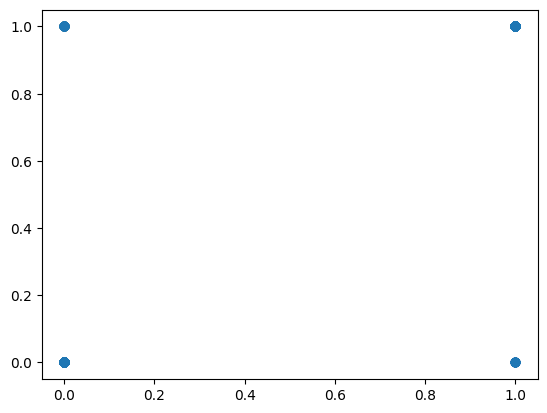

In [18]:
# # **Split data into training and test**
# with open('SNPorPD.txt', 'w+') as f:
#         data=f.read()
#         f.write(str(y_test.to_string()))

# # pipeline.fit(X, y) #applies list if transformers to give a fitted model

plt.scatter(Classes_test, Output_pred)

In [16]:
gridsearch = GridSearchCV( #validation
    estimator = LogisticRegression(solver='saga'),
    param_grid = {}, #dictionary of parameters to search through
    cv = StratifiedKFold(),
    n_jobs = 1, #how many processors to run in parallel
    scoring = 'f1',
    verbose = 3 
    ).fit(X_train, y_train)

NameError: name 'X_train' is not defined

In [ ]:
# y_pred = clf.predict(X_test)
# print("Training time:", stop-start)
# print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
# print("MCC:\n", matthews_corrcoef(y_test, y_pred))
# print("F1:\n", f1_score(y_test, y_pred))